In [11]:
import torch
import torch.nn as nn
import time
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint as ode_torch


class SNNCell(nn.Module):
    __constants__ = ['C_m', 'g_Na', 'g_K', 'g_L', 'E_Na', 'E_K', 'E_L']
    def __init__(self, device, input_size, hidden_size):
        super(SNNCell, self).__init__()
        self.C_m = 1.0; self.g_Na = 120.0; self.g_K = 36.0; self.g_L = 0.3
        self.E_Na = 50.0; self.E_K = -77.0; self.E_L = -54.387
        self.device = device
        self.hidden_size = hidden_size
        self.lin = nn.Linear(input_size, hidden_size, bias=True)
        
        self.init_parameters()
    
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
    
    def forward(self, t, state):
        dy = torch.zeros((4, self.hidden_size)).to(self.device)
        V, m, h, n = state
        _r_a = torch.randint(0, 10, (self.hidden_size, )).to(self.device)
        _activate = (torch.relu(self.lin(_i) - 1.0) > 0).float()
        
        dy[0] = (_r_a * _activate - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V))/self.C_m
        dy[1] = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m 
        dy[2] = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h 
        dy[3] = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dy
    
    def alpha_m(self, V): 
         return 0.1*(V+40.0)/(1 - torch.exp(-(V+40.0)/10.0))
    def beta_m(self, V): 
         return 4.0*torch.exp(-(V+65.0)/18.0)
    def alpha_h(self, V): 
         return 0.07*torch.exp(-(V+65.0)/20.0)
    def beta_h(self, V): 
         return 1.0/(1.0 + torch.exp(-(V+35.0)/10.0)) 
    def alpha_n(self, V): 
         return 0.01*(V+55.0)/(1.0 - torch.exp(-(V+55.0)/10.0))
    def beta_n(self, V): 
         return 0.125*torch.exp(-(V+65)/80.0)
    def I_Na(self, V, m, h): 
         return self.g_Na * torch.pow(m, 3.0) * h * (V - self.E_Na)
    def I_K(self, V, n): 
         return self.g_K * torch.pow(n, 4.0) * (V - self.E_K)
    def I_L(self, V): 
         return self.g_L * (V - self.E_L)



In [17]:
class InputDataToSpikingPerceptronLayer(nn.Module):
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        self.to(self.device)

    def forward(self, x):
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x


class SNN(nn.Module):
    def __init__(self, device, input_size, hidden_size, time_step=60, dt=0.1):
        super(SNN, self).__init__()
        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.time_step = time_step
        self.dt = dt
        
        self.input_to_spiking = InputDataToSpikingPerceptronLayer(self.device)
        self.spiking1 = SNNCell(self.device, input_size, self.hidden_size).to(self.device)
        self.init_parameters()
        self.reset_state()
        #self.to(self.device)    
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
                
    def reset_state(self):
        self.V = torch.zeros([self.hidden_size]).to(self.device)
        self.m = torch.zeros([self.hidden_size]).to(self.device)
        self.h = torch.zeros([self.hidden_size]).to(self.device)
        self.n = torch.zeros([self.hidden_size]).to(self.device)
        
    def forward(self, x):   
        self.V[:], self.m[:], self.h[:], self.n[:] = -60.0, 0.05, 0.6, 0.32
        _s = (self.V, self.m, self.h, self.n)
        _time = torch.arange(0.0, self.time_step, self.dt).to(self.device)
        global _i
        _i = self.input_to_spiking(x).to(self.device)
        _X = ode_torch(self.spiking1, _s, _time, rtol=1e-3, atol=1e-6, method='dopri5') # rto1=1e-6 More complex computing 
        
        return _X
       
hidden_size = 64 # Hidden_Size 1-Layer Neuron --- My_propose: 1024 ---
input_size=1024    # Change value  --- My_propose: 1920x1080 = 2073600 ---
device = "cpu" # "cpu" -- Multicore + gpu  | "cuda" --- singlecore + gpu
x = torch.randn(input_size).to(device)
model = SNN(device, input_size, hidden_size).to(device)

test = 10; test_score = list()
for i in range(test):
    start_time = time.time()
    X = model(x) #dopri5, euler, adams The best dopri5
    _time = time.time() - start_time
    test_score.append(_time)


############## My cpu: intel i7 9750H ##############
print("--- Max: {:.4f} s --- Min: {:.4f} s --- Mean: {:.4f} s --- Error: {:.4f} s---".format(np.max(test_score)
                                                                                            ,np.min(test_score), sp.mean(test_score),
                                                                                            sp.std(test_score)))


--- Max: 4.1681 s --- Min: 3.5617 s --- Mean: 3.8744 s --- Error: 0.1747 s---


Text(0.5, 0, 's (1e-1 s)')

<Figure size 432x288 with 0 Axes>

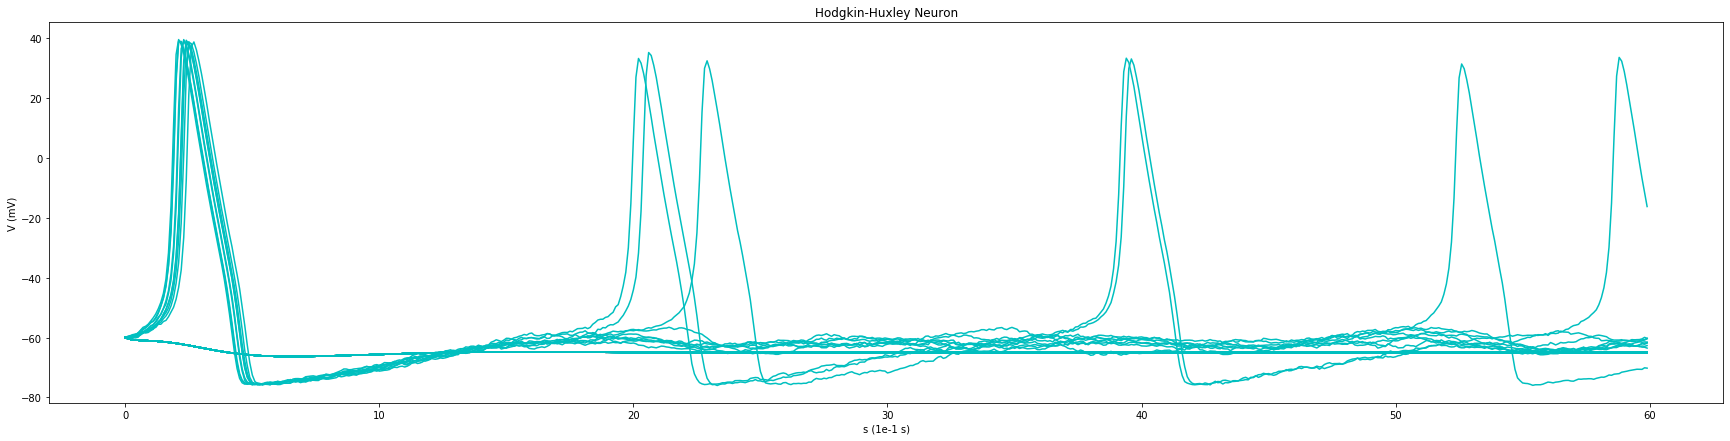

<Figure size 432x288 with 0 Axes>

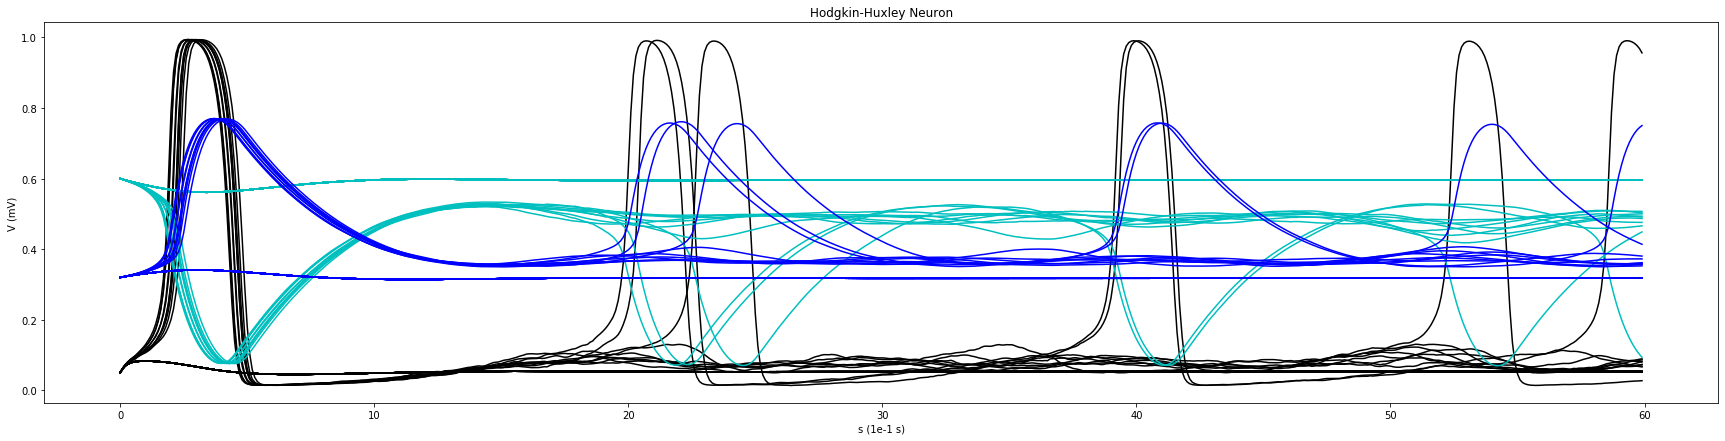

In [18]:
time_step=60;dt=0.1
t = torch.arange(0.0, time_step, dt).to(device)
plt.figure()
plt.subplots(figsize=(30, 7)) 
plt.title('Hodgkin-Huxley Neuron') 
plt.plot(t.cpu(), X[0].cpu(), 'c') #t, X[0]
plt.ylabel('V (mV)')
plt.xlabel('s (1e-1 s)')

plt.figure() 
plt.subplots(figsize=(30, 7)) 
plt.title('Hodgkin-Huxley Neuron') 
plt.plot(t.cpu(), X[1].cpu().detach().numpy(), 'k')
plt.plot(t.cpu(), X[2].cpu().detach().numpy(), 'c')
plt.plot(t.cpu(), X[3].cpu().detach().numpy(), 'b')
plt.ylabel('V (mV)')
plt.xlabel('s (1e-1 s)')